In [2]:
import pandas as pd
new_data = pd.read_csv("/Users/macbookpro/code/HayaAlsubie/Beyond_the_Stars/data/cleaned_reviews.csv")
new_data


,Region,City,Place Type,Place Category,Place Name,Rating,Review Text,Reviewer Language,cleaned_review,review_length,sentiment_label,Predicted Sentiment,Predicted Sentiment Label
0,North,Hail,hotel,lodging,Tamyoz Hotel Apartment,3.7,"Location is best, all good chains outlets avai...",en,location best good chains outlets available wi...,24,positive,1,positive
1,North,Hail,hotel,lodging,Tamyoz Hotel Apartment,3.7,Rooms are good enough to accommodate a family ...,en,rooms good enough accommodate family kids neat...,11,positive,1,positive
2,North,Hail,hotel,lodging,Tamyoz Hotel Apartment,3.7,"Just a reasonable cheap hotel, the price is th...",en,reasonable cheap hotel price main success factor,7,positive,1,positive
3,North,Hail,hotel,lodging,Tamyoz Hotel Apartment,3.7,We had a bad experience in reception. They did...,en,bad experience reception give rooms per bookin...,23,negative,0,negative
4,North,Hail,hotel,lodging,Tamyoz Hotel Apartment,3.7,One of the best and budget friendly hotels in ...,en,one best budget friendly hotels hail good swim...,11,positive,1,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,South,Jazan,amusement_park,amusement_park,Sparky's | سباركيز,3.5,Are you crasy. Why the price of the kids games...,en,crasy price kids games high mantioned price sr,8,negative,0,negative
17091,South,Jazan,amusement_park,amusement_park,Sparky's | سباركيز,3.5,Great place! Much fun with friends and family!,en,great place much fun friends family,6,positive,1,positive
17092,South,Jazan,amusement_park,amusement_park,Sparky's | سباركيز,3.5,Good collections of games and leasure for kids...,en,good collections games leasure kids cleaniness...,8,positive,1,positive
17093,South,Jazan,amusement_park,amusement_park,Sparky's | سباركيز,3.5,غااااااااالي غاااالي اقل شحن حوالي 600 سلامااا...,en-Arab,غااااااااالي غاااالي اقل شحن حوالي سلامااااااا...,14,negative,0,negative


In [11]:
new_data["Predicted Sentiment Label"].value_counts()


Predicted Sentiment Label
positive    14265
negative     2830
Name: count, dtype: int64

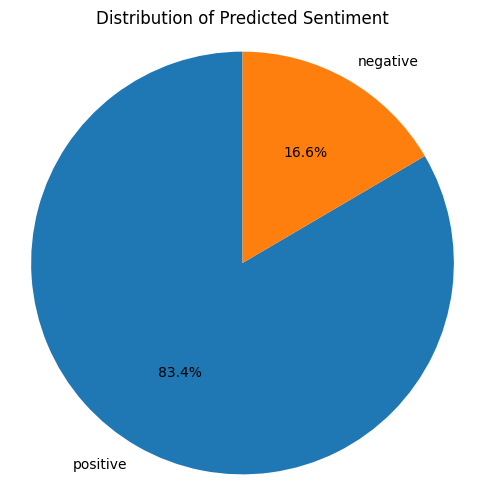

In [12]:
import matplotlib.pyplot as plt

# حساب عدد كل نوع من المشاعر
counts = new_data["Predicted Sentiment Label"].value_counts()

# إعداد البيانات
labels = counts.index
sizes = counts.values

# رسم المخطط الدائري
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Predicted Sentiment")
plt.axis('equal')  # يضمن أن يكون الدائرة بشكل دائري تمامًا
plt.show()


In [8]:
new_data.groupby(["City", "Place Type"]).size().reset_index(name="Review Count")


,City,Place Type,Review Count
0,Abha,amusement_park,5
1,Abha,cafe,122
2,Abha,hotel,283
3,Abha,museum,29
4,Abha,park,14
...,...,...,...
150,Yanbu,museum,9
151,Yanbu,park,10
152,Yanbu,restaurant,289
153,Yanbu,shopping_mall,94


In [12]:
import pandas as pd
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import nltk
from nltk.corpus import stopwords

# تحميل stopwords فقط إذا لم تكن موجودة مسبقًا
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# تحميل البيانات
new_data = pd.read_csv("/Users/macbookpro/code/HayaAlsubie/Beyond_the_Stars/data/cleaned_reviews.csv")

# إعداد كلمات التوقف
english_stopwords = set(stopwords.words('english'))
arabic_stopwords = set(stopwords.words('arabic'))

# دالة تنظيف مخصصة لكل لغة
def clean_tokens(text, lang="en"):
    tokens = text.lower().split()
    if lang == "en":
        return [word for word in tokens if word not in english_stopwords and word.isalpha()]
    else:
        return [word for word in tokens if word not in arabic_stopwords and word.isalpha()]

# ───────────────────────────────────────────────
# استخراج التوبيكز لكل مدينة (لغة إنجليزية فقط)
# ───────────────────────────────────────────────

city_topics = {}  # لحفظ نتائج كل مدينة

for city in new_data["City"].unique():
    city_data = new_data[
        (new_data["City"] == city) &
        (new_data["Reviewer Language"] == "en") &
        new_data["cleaned_review"].notnull()
    ]

    if len(city_data) < 50:
        continue  # نتجاوز المدن ذات البيانات القليلة

    city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))

    tokens = city_data["tokens"]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(text) for text in tokens]

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=9, passes=10, random_state=42)

    city_topics[city] = lda_model.print_topics()

    print(f"\n\n🌆 Topics for {city}:")
    for idx, topic in city_topics[city]:
        print(f"Topic {idx+1}: {topic}\n")


/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Hail:
Topic 1: 0.031*"good" + 0.024*"food" + 0.014*"staff" + 0.013*"place" + 0.010*"clean" + 0.010*"room" + 0.009*"service" + 0.008*"hotel" + 0.008*"one" + 0.008*"time"

Topic 2: 0.029*"good" + 0.021*"nice" + 0.018*"place" + 0.013*"hail" + 0.012*"hotel" + 0.009*"coffee" + 0.009*"also" + 0.009*"visit" + 0.008*"one" + 0.007*"much"

Topic 3: 0.050*"good" + 0.026*"place" + 0.020*"service" + 0.018*"clean" + 0.018*"nice" + 0.010*"great" + 0.010*"hail" + 0.009*"food" + 0.009*"staff" + 0.007*"prices"

Topic 4: 0.024*"food" + 0.012*"service" + 0.012*"restaurant" + 0.010*"place" + 0.010*"good" + 0.010*"also" + 0.009*"delicious" + 0.008*"staff" + 0.008*"chicken" + 0.007*"like"

Topic 5: 0.021*"place" + 0.017*"nice" + 0.014*"hail" + 0.012*"food" + 0.012*"beautiful" + 0.011*"coffee" + 0.011*"family" + 0.011*"park" + 0.009*"view" + 0.009*"staff"

Topic 6: 0.019*"hail" + 0.019*"hotel" + 0.015*"best" + 0.012*"good" + 0.012*"one" + 0.011*"experience" + 0.011*"food" + 0.011*"room" + 0.010

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Umluj:
Topic 1: 0.012*"good" + 0.010*"place" + 0.009*"nice" + 0.008*"staff" + 0.007*"hotel" + 0.007*"shawarma" + 0.006*"recommend" + 0.006*"service" + 0.005*"experience" + 0.005*"umluj"

Topic 2: 0.020*"good" + 0.019*"staff" + 0.015*"hotel" + 0.012*"great" + 0.011*"service" + 0.011*"friendly" + 0.010*"food" + 0.010*"umluj" + 0.010*"experience" + 0.009*"tasty"

Topic 3: 0.017*"food" + 0.015*"good" + 0.014*"nice" + 0.011*"stay" + 0.009*"hotel" + 0.009*"taste" + 0.008*"place" + 0.008*"service" + 0.007*"great" + 0.007*"coffee"

Topic 4: 0.015*"amazing" + 0.014*"sea" + 0.013*"great" + 0.012*"clean" + 0.011*"view" + 0.011*"one" + 0.010*"experience" + 0.010*"staff" + 0.009*"every" + 0.008*"us"

Topic 5: 0.018*"place" + 0.015*"good" + 0.013*"hotel" + 0.010*"food" + 0.010*"umluj" + 0.010*"beautiful" + 0.009*"great" + 0.009*"clean" + 0.008*"nice" + 0.008*"really"

Topic 6: 0.018*"good" + 0.016*"place" + 0.013*"coffee" + 0.012*"best" + 0.011*"beach" + 0.010*"staff" + 0.009*"also" +

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Unaizah:
Topic 1: 0.017*"good" + 0.016*"place" + 0.013*"chicken" + 0.012*"time" + 0.009*"food" + 0.009*"order" + 0.007*"also" + 0.007*"like" + 0.007*"coffee" + 0.006*"area"

Topic 2: 0.035*"good" + 0.018*"delicious" + 0.018*"place" + 0.012*"service" + 0.011*"coffee" + 0.010*"nice" + 0.009*"restaurant" + 0.009*"clean" + 0.008*"chicken" + 0.008*"food"

Topic 3: 0.024*"food" + 0.017*"best" + 0.013*"one" + 0.012*"delicious" + 0.010*"restaurant" + 0.010*"order" + 0.010*"tasty" + 0.009*"service" + 0.009*"good" + 0.009*"eat"

Topic 4: 0.019*"place" + 0.017*"good" + 0.008*"service" + 0.008*"best" + 0.007*"food" + 0.007*"great" + 0.007*"like" + 0.006*"large" + 0.006*"taste" + 0.005*"cold"

Topic 5: 0.036*"place" + 0.027*"nice" + 0.024*"good" + 0.016*"food" + 0.012*"staff" + 0.009*"taste" + 0.008*"one" + 0.008*"amazing" + 0.007*"service" + 0.007*"especially"

Topic 6: 0.063*"good" + 0.016*"food" + 0.015*"nice" + 0.012*"like" + 0.009*"service" + 0.008*"time" + 0.008*"price" + 0.007

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Mecca:
Topic 1: 0.014*"food" + 0.013*"place" + 0.008*"great" + 0.008*"good" + 0.007*"well" + 0.006*"makkah" + 0.006*"taste" + 0.006*"people" + 0.005*"find" + 0.005*"also"

Topic 2: 0.019*"hotel" + 0.018*"food" + 0.015*"service" + 0.015*"good" + 0.011*"staff" + 0.011*"haram" + 0.008*"nice" + 0.008*"great" + 0.008*"restaurant" + 0.008*"experience"

Topic 3: 0.019*"good" + 0.017*"food" + 0.014*"coffee" + 0.011*"service" + 0.010*"staff" + 0.009*"great" + 0.008*"place" + 0.008*"one" + 0.007*"also" + 0.007*"nice"

Topic 4: 0.011*"hotel" + 0.010*"good" + 0.009*"service" + 0.008*"place" + 0.007*"also" + 0.007*"rooms" + 0.007*"one" + 0.007*"staff" + 0.006*"us" + 0.005*"food"

Topic 5: 0.026*"hotel" + 0.013*"room" + 0.010*"service" + 0.010*"stay" + 0.007*"location" + 0.007*"staff" + 0.007*"experience" + 0.006*"recommend" + 0.006*"bus" + 0.006*"us"

Topic 6: 0.011*"place" + 0.009*"hotel" + 0.008*"best" + 0.008*"nice" + 0.008*"food" + 0.007*"great" + 0.007*"service" + 0.007*"makkah"

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Buraidah:
Topic 1: 0.021*"place" + 0.020*"coffee" + 0.016*"food" + 0.012*"one" + 0.012*"good" + 0.011*"service" + 0.010*"nice" + 0.009*"best" + 0.009*"restaurant" + 0.008*"really"

Topic 2: 0.025*"good" + 0.014*"nice" + 0.012*"place" + 0.011*"food" + 0.011*"delicious" + 0.010*"staff" + 0.008*"restaurant" + 0.008*"chicken" + 0.008*"best" + 0.007*"helpful"

Topic 3: 0.016*"good" + 0.009*"staff" + 0.007*"room" + 0.007*"also" + 0.007*"place" + 0.007*"nice" + 0.006*"service" + 0.006*"great" + 0.005*"coffee" + 0.005*"time"

Topic 4: 0.065*"good" + 0.033*"food" + 0.027*"place" + 0.021*"nice" + 0.020*"service" + 0.018*"staff" + 0.012*"restaurant" + 0.011*"hotel" + 0.010*"tasty" + 0.010*"clean"

Topic 5: 0.012*"great" + 0.012*"room" + 0.009*"time" + 0.008*"good" + 0.008*"clean" + 0.008*"stay" + 0.008*"food" + 0.007*"experience" + 0.007*"hospitality" + 0.006*"place"

Topic 6: 0.019*"room" + 0.016*"good" + 0.012*"staff" + 0.012*"price" + 0.010*"clean" + 0.009*"service" + 0.009*"hot

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Al Ahsa:
Topic 1: 0.024*"good" + 0.016*"taste" + 0.016*"place" + 0.015*"food" + 0.014*"service" + 0.012*"staff" + 0.012*"nice" + 0.009*"chicken" + 0.009*"friendly" + 0.008*"restaurant"

Topic 2: 0.041*"good" + 0.015*"place" + 0.015*"coffee" + 0.013*"service" + 0.013*"great" + 0.011*"hotel" + 0.010*"staff" + 0.009*"experience" + 0.008*"clean" + 0.007*"nice"

Topic 3: 0.011*"place" + 0.010*"food" + 0.010*"coffee" + 0.008*"experience" + 0.008*"best" + 0.008*"service" + 0.008*"staff" + 0.007*"restaurant" + 0.007*"good" + 0.007*"one"

Topic 4: 0.013*"good" + 0.010*"hotel" + 0.010*"staff" + 0.008*"stay" + 0.007*"like" + 0.006*"great" + 0.006*"one" + 0.006*"service" + 0.006*"experience" + 0.006*"place"

Topic 5: 0.018*"food" + 0.018*"place" + 0.018*"good" + 0.010*"nice" + 0.009*"clean" + 0.008*"well" + 0.008*"best" + 0.008*"al" + 0.007*"one" + 0.007*"price"

Topic 6: 0.017*"hotel" + 0.013*"nice" + 0.010*"food" + 0.009*"good" + 0.008*"best" + 0.008*"restaurant" + 0.007*"well" + 

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for AlUla:
Topic 1: 0.016*"place" + 0.010*"coffee" + 0.009*"great" + 0.008*"service" + 0.008*"well" + 0.007*"visit" + 0.007*"ula" + 0.007*"al" + 0.007*"like" + 0.007*"nice"

Topic 2: 0.019*"food" + 0.018*"place" + 0.012*"good" + 0.009*"service" + 0.008*"really" + 0.008*"recommend" + 0.007*"best" + 0.007*"restaurant" + 0.006*"amazing" + 0.006*"chicken"

Topic 3: 0.014*"place" + 0.010*"also" + 0.009*"food" + 0.009*"good" + 0.008*"one" + 0.008*"alula" + 0.007*"restaurant" + 0.007*"see" + 0.006*"experience" + 0.006*"service"

Topic 4: 0.020*"great" + 0.018*"food" + 0.016*"service" + 0.014*"delicious" + 0.014*"place" + 0.012*"friendly" + 0.012*"experience" + 0.011*"restaurant" + 0.010*"chicken" + 0.009*"atmosphere"

Topic 5: 0.009*"alula" + 0.009*"place" + 0.008*"experience" + 0.007*"food" + 0.006*"really" + 0.006*"staff" + 0.005*"nice" + 0.005*"good" + 0.005*"stay" + 0.005*"pool"

Topic 6: 0.018*"us" + 0.011*"stay" + 0.011*"experience" + 0.011*"hotel" + 0.008*"recommend" + 0.008

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Jeddah:
Topic 1: 0.015*"mall" + 0.012*"place" + 0.011*"good" + 0.010*"food" + 0.010*"shopping" + 0.008*"also" + 0.008*"great" + 0.007*"best" + 0.007*"kids" + 0.006*"shops"

Topic 2: 0.012*"amazing" + 0.012*"food" + 0.011*"experience" + 0.010*"place" + 0.008*"service" + 0.008*"time" + 0.007*"definitely" + 0.007*"delicious" + 0.007*"well" + 0.006*"beautiful"

Topic 3: 0.018*"nice" + 0.012*"mall" + 0.009*"staff" + 0.009*"good" + 0.008*"clean" + 0.008*"hotel" + 0.008*"one" + 0.007*"place" + 0.007*"best" + 0.006*"shops"

Topic 4: 0.014*"one" + 0.012*"hotel" + 0.011*"good" + 0.010*"service" + 0.009*"park" + 0.009*"staff" + 0.009*"jeddah" + 0.008*"rooms" + 0.007*"stay" + 0.007*"recommend"

Topic 5: 0.015*"place" + 0.012*"nice" + 0.011*"service" + 0.010*"good" + 0.009*"coffee" + 0.008*"food" + 0.008*"also" + 0.007*"one" + 0.007*"clean" + 0.006*"us"

Topic 6: 0.013*"food" + 0.008*"experience" + 0.008*"jeddah" + 0.008*"restaurant" + 0.007*"coffee" + 0.007*"good" + 0.006*"gate" + 0

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Abha:
Topic 1: 0.019*"good" + 0.013*"food" + 0.008*"best" + 0.008*"us" + 0.007*"hotel" + 0.007*"service" + 0.006*"abha" + 0.006*"really" + 0.006*"restaurant" + 0.006*"visit"

Topic 2: 0.040*"good" + 0.017*"food" + 0.016*"place" + 0.013*"service" + 0.011*"staff" + 0.010*"best" + 0.008*"delicious" + 0.008*"coffee" + 0.007*"restaurant" + 0.007*"available"

Topic 3: 0.014*"food" + 0.013*"place" + 0.013*"good" + 0.013*"abha" + 0.012*"hotel" + 0.009*"one" + 0.008*"coffee" + 0.007*"restaurant" + 0.007*"nice" + 0.007*"clean"

Topic 4: 0.014*"service" + 0.014*"staff" + 0.014*"good" + 0.013*"nice" + 0.012*"hotel" + 0.012*"great" + 0.011*"room" + 0.009*"rooms" + 0.009*"food" + 0.009*"place"

Topic 5: 0.013*"good" + 0.010*"food" + 0.009*"hotel" + 0.008*"great" + 0.008*"also" + 0.007*"really" + 0.007*"coffee" + 0.006*"mall" + 0.006*"service" + 0.006*"recommend"

Topic 6: 0.026*"place" + 0.013*"good" + 0.013*"hotel" + 0.009*"staff" + 0.009*"clean" + 0.008*"nice" + 0.007*"beautiful" + 

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Medina:
Topic 1: 0.033*"hotel" + 0.023*"room" + 0.011*"service" + 0.011*"experience" + 0.011*"rooms" + 0.010*"staff" + 0.008*"clean" + 0.007*"bad" + 0.007*"bathroom" + 0.007*"stay"

Topic 2: 0.019*"place" + 0.015*"food" + 0.012*"good" + 0.009*"best" + 0.008*"service" + 0.008*"restaurant" + 0.008*"staff" + 0.008*"amazing" + 0.006*"one" + 0.006*"nice"

Topic 3: 0.014*"good" + 0.011*"food" + 0.009*"nice" + 0.007*"coffee" + 0.007*"place" + 0.006*"restaurant" + 0.006*"would" + 0.006*"museum" + 0.006*"like" + 0.005*"madinah"

Topic 4: 0.013*"time" + 0.009*"hotel" + 0.009*"room" + 0.008*"good" + 0.007*"like" + 0.007*"dont" + 0.007*"place" + 0.006*"also" + 0.005*"bus" + 0.005*"people"

Topic 5: 0.010*"place" + 0.008*"staff" + 0.007*"hotel" + 0.007*"park" + 0.006*"experience" + 0.006*"food" + 0.005*"time" + 0.005*"stay" + 0.005*"us" + 0.005*"nice"

Topic 6: 0.013*"mosque" + 0.009*"prophet" + 0.009*"quba" + 0.008*"allah" + 0.007*"masjid" + 0.007*"peace" + 0.007*"history" + 0.007*"

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Khobar:
Topic 1: 0.009*"place" + 0.008*"coffee" + 0.007*"good" + 0.007*"kids" + 0.006*"games" + 0.006*"hotel" + 0.006*"area" + 0.006*"would" + 0.005*"staff" + 0.005*"rides"

Topic 2: 0.023*"place" + 0.016*"food" + 0.013*"good" + 0.010*"nice" + 0.009*"service" + 0.009*"staff" + 0.009*"delicious" + 0.009*"coffee" + 0.009*"great" + 0.009*"visit"

Topic 3: 0.014*"place" + 0.010*"hotel" + 0.008*"good" + 0.008*"staff" + 0.008*"also" + 0.008*"clean" + 0.007*"nice" + 0.007*"coffee" + 0.007*"food" + 0.006*"one"

Topic 4: 0.015*"room" + 0.012*"service" + 0.009*"one" + 0.009*"rooms" + 0.008*"hotel" + 0.007*"food" + 0.006*"staff" + 0.006*"bad" + 0.006*"experience" + 0.005*"area"

Topic 5: 0.015*"coffee" + 0.013*"good" + 0.010*"place" + 0.007*"area" + 0.007*"mall" + 0.006*"great" + 0.005*"time" + 0.005*"clean" + 0.005*"food" + 0.005*"kids"

Topic 6: 0.022*"place" + 0.013*"great" + 0.013*"good" + 0.013*"service" + 0.012*"staff" + 0.010*"nice" + 0.010*"food" + 0.010*"hotel" + 0.009*"st

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Taif:
Topic 1: 0.014*"good" + 0.011*"service" + 0.010*"amazing" + 0.009*"experience" + 0.008*"us" + 0.008*"place" + 0.008*"one" + 0.007*"restaurant" + 0.006*"great" + 0.006*"beautiful"

Topic 2: 0.018*"hotel" + 0.008*"experience" + 0.008*"ride" + 0.008*"good" + 0.007*"also" + 0.006*"clean" + 0.006*"one" + 0.006*"taif" + 0.006*"staff" + 0.005*"rooms"

Topic 3: 0.027*"good" + 0.025*"service" + 0.022*"food" + 0.021*"staff" + 0.012*"hotel" + 0.010*"friendly" + 0.010*"place" + 0.009*"stay" + 0.009*"great" + 0.008*"excellent"

Topic 4: 0.020*"restaurant" + 0.012*"bad" + 0.011*"good" + 0.007*"quality" + 0.007*"service" + 0.006*"us" + 0.005*"taif" + 0.005*"food" + 0.005*"experience" + 0.005*"like"

Topic 5: 0.038*"place" + 0.013*"taif" + 0.011*"mall" + 0.009*"kids" + 0.009*"enjoy" + 0.008*"beautiful" + 0.008*"nice" + 0.008*"food" + 0.008*"visit" + 0.008*"like"

Topic 6: 0.018*"good" + 0.014*"food" + 0.013*"chicken" + 0.012*"place" + 0.012*"nice" + 0.012*"friendly" + 0.011*"servi

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Al Baha:
Topic 1: 0.030*"place" + 0.021*"good" + 0.016*"food" + 0.013*"one" + 0.011*"nice" + 0.010*"amazing" + 0.009*"best" + 0.009*"al" + 0.009*"great" + 0.008*"baha"

Topic 2: 0.015*"food" + 0.013*"good" + 0.010*"service" + 0.009*"clean" + 0.007*"place" + 0.007*"nice" + 0.006*"well" + 0.006*"family" + 0.006*"lovely" + 0.006*"one"

Topic 3: 0.020*"good" + 0.018*"service" + 0.015*"bad" + 0.011*"place" + 0.009*"food" + 0.008*"excellent" + 0.008*"taste" + 0.007*"coffee" + 0.007*"order" + 0.006*"atmosphere"

Topic 4: 0.015*"good" + 0.013*"best" + 0.012*"food" + 0.011*"burger" + 0.010*"baha" + 0.010*"al" + 0.008*"prices" + 0.008*"chicken" + 0.007*"taste" + 0.006*"tasty"

Topic 5: 0.021*"good" + 0.019*"food" + 0.018*"staff" + 0.015*"hotel" + 0.010*"one" + 0.009*"clean" + 0.009*"best" + 0.009*"nice" + 0.008*"service" + 0.007*"place"

Topic 6: 0.045*"good" + 0.017*"nice" + 0.015*"clean" + 0.015*"place" + 0.014*"hotel" + 0.012*"staff" + 0.011*"location" + 0.010*"room" + 0.010*"s

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Najran:
Topic 1: 0.036*"food" + 0.018*"good" + 0.013*"staff" + 0.011*"delicious" + 0.010*"place" + 0.010*"amazing" + 0.008*"taste" + 0.008*"coffee" + 0.008*"like" + 0.007*"time"

Topic 2: 0.046*"good" + 0.044*"nice" + 0.029*"staff" + 0.026*"place" + 0.021*"clean" + 0.017*"service" + 0.016*"food" + 0.016*"great" + 0.016*"restaurant" + 0.014*"hotel"

Topic 3: 0.033*"good" + 0.018*"hotel" + 0.016*"nice" + 0.016*"place" + 0.013*"service" + 0.012*"room" + 0.012*"food" + 0.012*"staff" + 0.007*"great" + 0.007*"location"

Topic 4: 0.014*"service" + 0.012*"good" + 0.010*"staff" + 0.010*"coffee" + 0.010*"one" + 0.010*"restaurant" + 0.010*"bad" + 0.007*"clean" + 0.007*"time" + 0.007*"thanks"

Topic 5: 0.054*"best" + 0.033*"coffee" + 0.019*"najran" + 0.016*"burger" + 0.014*"place" + 0.013*"delicious" + 0.013*"good" + 0.012*"shop" + 0.011*"nice" + 0.009*"much"

Topic 6: 0.036*"good" + 0.021*"place" + 0.016*"staff" + 0.015*"clean" + 0.009*"service" + 0.008*"hotel" + 0.008*"great" + 0.

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Tabuk:
Topic 1: 0.013*"good" + 0.013*"food" + 0.008*"service" + 0.008*"place" + 0.007*"restaurant" + 0.007*"experience" + 0.006*"also" + 0.006*"tabuk" + 0.006*"staff" + 0.005*"biryani"

Topic 2: 0.022*"good" + 0.022*"place" + 0.011*"food" + 0.009*"also" + 0.009*"one" + 0.006*"need" + 0.006*"small" + 0.006*"staff" + 0.006*"really" + 0.006*"every"

Topic 3: 0.020*"good" + 0.017*"hotel" + 0.014*"best" + 0.012*"tabuk" + 0.010*"service" + 0.010*"stay" + 0.010*"room" + 0.008*"nice" + 0.008*"experience" + 0.007*"place"

Topic 4: 0.020*"place" + 0.020*"coffee" + 0.016*"good" + 0.015*"best" + 0.014*"great" + 0.012*"tabuk" + 0.012*"food" + 0.011*"service" + 0.011*"one" + 0.011*"restaurant"

Topic 5: 0.035*"good" + 0.023*"service" + 0.020*"staff" + 0.019*"hotel" + 0.018*"food" + 0.017*"clean" + 0.014*"place" + 0.011*"stay" + 0.011*"friendly" + 0.010*"amazing"

Topic 6: 0.017*"good" + 0.016*"food" + 0.012*"price" + 0.010*"experience" + 0.007*"high" + 0.007*"prices" + 0.007*"try" + 0

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Qatif:
Topic 1: 0.010*"place" + 0.009*"great" + 0.009*"food" + 0.007*"experience" + 0.006*"qatif" + 0.006*"prices" + 0.006*"staff" + 0.005*"chicken" + 0.005*"dishes" + 0.005*"good"

Topic 2: 0.020*"good" + 0.011*"food" + 0.011*"chicken" + 0.008*"place" + 0.008*"shawarma" + 0.008*"taste" + 0.007*"also" + 0.007*"one" + 0.006*"delicious" + 0.006*"staff"

Topic 3: 0.019*"place" + 0.015*"coffee" + 0.012*"service" + 0.009*"good" + 0.009*"experience" + 0.009*"amazing" + 0.008*"food" + 0.008*"great" + 0.008*"visit" + 0.007*"staff"

Topic 4: 0.015*"food" + 0.014*"place" + 0.013*"restaurant" + 0.012*"great" + 0.011*"best" + 0.011*"good" + 0.010*"staff" + 0.010*"nice" + 0.009*"delicious" + 0.009*"one"

Topic 5: 0.040*"good" + 0.017*"service" + 0.013*"room" + 0.012*"food" + 0.011*"place" + 0.010*"nice" + 0.008*"hotel" + 0.008*"one" + 0.007*"staff" + 0.007*"also"

Topic 6: 0.030*"place" + 0.027*"good" + 0.012*"clean" + 0.010*"kids" + 0.009*"food" + 0.009*"best" + 0.008*"staff" + 0.00

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Rijal Alma:
Topic 1: 0.031*"good" + 0.027*"hotel" + 0.014*"clean" + 0.009*"rooms" + 0.009*"room" + 0.007*"near" + 0.007*"staff" + 0.007*"available" + 0.006*"well" + 0.005*"service"

Topic 2: 0.049*"good" + 0.023*"nice" + 0.022*"place" + 0.022*"location" + 0.019*"clean" + 0.018*"service" + 0.017*"hotel" + 0.015*"best" + 0.012*"rooms" + 0.012*"room"

Topic 3: 0.018*"one" + 0.015*"best" + 0.014*"room" + 0.011*"stay" + 0.010*"place" + 0.010*"meters" + 0.010*"abha" + 0.008*"dam" + 0.008*"clean" + 0.007*"hotel"

Topic 4: 0.042*"hotel" + 0.014*"best" + 0.013*"staff" + 0.012*"clean" + 0.012*"room" + 0.010*"good" + 0.008*"nice" + 0.008*"rijal" + 0.008*"kind" + 0.008*"small"

Topic 5: 0.015*"view" + 0.012*"beautiful" + 0.012*"best" + 0.010*"place" + 0.010*"good" + 0.009*"amazing" + 0.009*"must" + 0.009*"restaurant" + 0.009*"lamb" + 0.009*"bad"

Topic 6: 0.024*"hotel" + 0.016*"room" + 0.013*"great" + 0.011*"location" + 0.009*"service" + 0.009*"rooms" + 0.008*"clean" + 0.007*"price"

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Yanbu:
Topic 1: 0.018*"good" + 0.016*"nice" + 0.015*"place" + 0.009*"best" + 0.007*"staff" + 0.007*"coffee" + 0.007*"food" + 0.007*"menu" + 0.006*"new" + 0.006*"restaurant"

Topic 2: 0.015*"yanbu" + 0.012*"place" + 0.012*"food" + 0.012*"good" + 0.011*"one" + 0.010*"restaurant" + 0.010*"fish" + 0.009*"service" + 0.008*"time" + 0.007*"hotel"

Topic 3: 0.017*"great" + 0.013*"place" + 0.013*"food" + 0.013*"good" + 0.011*"service" + 0.011*"coffee" + 0.009*"restaurant" + 0.009*"experience" + 0.009*"chicken" + 0.007*"staff"

Topic 4: 0.016*"good" + 0.013*"available" + 0.013*"place" + 0.009*"best" + 0.009*"food" + 0.009*"coffee" + 0.008*"area" + 0.007*"like" + 0.007*"kids" + 0.006*"yanbu"

Topic 5: 0.018*"yanbu" + 0.014*"good" + 0.013*"place" + 0.011*"nice" + 0.008*"food" + 0.007*"area" + 0.007*"hotel" + 0.006*"best" + 0.006*"stay" + 0.005*"beautiful"

Topic 6: 0.050*"good" + 0.012*"clean" + 0.010*"coffee" + 0.009*"food" + 0.009*"hotel" + 0.009*"service" + 0.009*"place" + 0.008*

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Riyadh:
Topic 1: 0.018*"experience" + 0.014*"service" + 0.012*"food" + 0.011*"great" + 0.009*"staff" + 0.008*"coffee" + 0.008*"restaurant" + 0.008*"amazing" + 0.008*"highly" + 0.008*"made"

Topic 2: 0.007*"room" + 0.007*"service" + 0.007*"stay" + 0.006*"hospitality" + 0.006*"rooms" + 0.006*"one" + 0.006*"staff" + 0.006*"great" + 0.006*"every" + 0.005*"also"

Topic 3: 0.022*"place" + 0.011*"kids" + 0.009*"good" + 0.008*"nice" + 0.008*"visit" + 0.007*"one" + 0.007*"like" + 0.007*"riyadh" + 0.007*"food" + 0.006*"games"

Topic 4: 0.017*"experience" + 0.010*"dining" + 0.007*"youre" + 0.007*"mall" + 0.007*"riyadh" + 0.007*"al" + 0.006*"perfect" + 0.006*"service" + 0.005*"mustvisit" + 0.005*"time"

Topic 5: 0.024*"good" + 0.022*"food" + 0.017*"place" + 0.014*"service" + 0.009*"nice" + 0.009*"restaurant" + 0.008*"great" + 0.007*"delicious" + 0.007*"experience" + 0.007*"chicken"

Topic 6: 0.014*"good" + 0.013*"park" + 0.008*"parking" + 0.007*"place" + 0.006*"hotel" + 0.006*"area"

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1338452089.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Jazan:
Topic 1: 0.026*"good" + 0.016*"service" + 0.013*"great" + 0.011*"bad" + 0.010*"nice" + 0.010*"hotel" + 0.010*"room" + 0.009*"coffee" + 0.009*"staff" + 0.009*"place"

Topic 2: 0.019*"place" + 0.018*"good" + 0.011*"food" + 0.011*"nice" + 0.010*"best" + 0.008*"clean" + 0.008*"mall" + 0.006*"experience" + 0.006*"great" + 0.005*"jazan"

Topic 3: 0.020*"room" + 0.018*"hotel" + 0.012*"clean" + 0.011*"great" + 0.010*"staff" + 0.009*"food" + 0.009*"service" + 0.008*"stay" + 0.008*"one" + 0.006*"good"

Topic 4: 0.016*"restaurant" + 0.015*"good" + 0.012*"hotel" + 0.010*"food" + 0.009*"coffee" + 0.009*"taste" + 0.007*"one" + 0.006*"rooms" + 0.006*"staff" + 0.006*"best"

Topic 5: 0.013*"place" + 0.013*"great" + 0.011*"coffee" + 0.009*"amazing" + 0.009*"staff" + 0.009*"price" + 0.009*"highly" + 0.008*"cake" + 0.007*"go" + 0.007*"recommended"

Topic 6: 0.042*"good" + 0.031*"place" + 0.027*"food" + 0.024*"nice" + 0.020*"service" + 0.013*"clean" + 0.013*"coffee" + 0.012*"staff" + 

In [13]:
import pandas as pd
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import nltk
from nltk.corpus import stopwords

# تحميل stopwords فقط إذا لم تكن موجودة مسبقًا
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# تحميل البيانات
new_data = pd.read_csv("/Users/macbookpro/code/HayaAlsubie/Beyond_the_Stars/data/cleaned_reviews.csv")

# إعداد كلمات التوقف
english_stopwords = set(stopwords.words('english'))
arabic_stopwords = set(stopwords.words('arabic'))

# دالة تنظيف مخصصة لكل لغة
def clean_tokens(text, lang="en"):
    tokens = text.lower().split()
    if lang == "en":
        return [word for word in tokens if word not in english_stopwords and word.isalpha()]
    else:
        return [word for word in tokens if word not in arabic_stopwords and word.isalpha()]

# ───────────────────────────────────────────────
# استخراج التوبيكز السلبية لكل مدينة (إنجليزي فقط)
# ───────────────────────────────────────────────

city_negative_topics = {}  # لحفظ نتائج التوبيكز السلبية لكل مدينة

for city in new_data["City"].unique():
    city_data = new_data[
        (new_data["City"] == city) &
        (new_data["Reviewer Language"] == "en") &
        (new_data["Predicted Sentiment Label"] == "negative") &  # ✅ فقط المراجعات السلبية
        new_data["cleaned_review"].notnull()
    ]

    if len(city_data) < 50:
        continue  # نتجاوز المدن ذات البيانات القليلة

    city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))

    tokens = city_data["tokens"]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(text) for text in tokens]

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)

    city_negative_topics[city] = lda_model.print_topics()

    print(f"\n\n🌆 Topics for {city} (negative sentiment):")
    for idx, topic in city_negative_topics[city]:
        print(f"Topic {idx+1}: {topic}\n")


/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Hail (negative sentiment):
Topic 1: 0.022*"bad" + 0.010*"service" + 0.010*"wasnt" + 0.008*"recommend" + 0.008*"asked" + 0.008*"experience" + 0.008*"us" + 0.008*"could" + 0.005*"place" + 0.005*"order"

Topic 2: 0.010*"restaurant" + 0.008*"even" + 0.008*"service" + 0.008*"available" + 0.008*"bad" + 0.005*"people" + 0.005*"night" + 0.005*"clean" + 0.005*"dont" + 0.005*"food"

Topic 3: 0.020*"bad" + 0.018*"service" + 0.009*"time" + 0.009*"rooms" + 0.009*"reception" + 0.009*"shower" + 0.007*"staff" + 0.007*"expensive" + 0.007*"guy" + 0.007*"room"

Topic 4: 0.017*"hotel" + 0.011*"room" + 0.010*"bad" + 0.009*"old" + 0.009*"staff" + 0.009*"time" + 0.009*"breakfast" + 0.009*"poor" + 0.007*"food" + 0.007*"furniture"

Topic 5: 0.015*"bad" + 0.014*"food" + 0.010*"service" + 0.010*"qishlah" + 0.008*"bin" + 0.008*"hotel" + 0.008*"location" + 0.008*"visit" + 0.006*"rooms" + 0.006*"much"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Umluj (negative sentiment):
Topic 1: 0.021*"sea" + 0.017*"rude" + 0.017*"us" + 0.013*"also" + 0.013*"service" + 0.013*"receptionist" + 0.009*"food" + 0.009*"bad" + 0.009*"worst" + 0.009*"room"

Topic 2: 0.020*"food" + 0.018*"bad" + 0.013*"area" + 0.012*"stay" + 0.009*"umluj" + 0.008*"good" + 0.008*"like" + 0.008*"experience" + 0.006*"place" + 0.006*"receptionist"

Topic 3: 0.032*"one" + 0.014*"market" + 0.014*"dont" + 0.013*"time" + 0.013*"know" + 0.013*"umluj" + 0.010*"bed" + 0.010*"want" + 0.010*"korma" + 0.010*"stores"

Topic 4: 0.017*"hotel" + 0.015*"tasty" + 0.012*"available" + 0.009*"doesnt" + 0.009*"price" + 0.009*"rude" + 0.009*"service" + 0.009*"stay" + 0.009*"staff" + 0.009*"disappointing"

Topic 5: 0.032*"bad" + 0.014*"like" + 0.011*"location" + 0.008*"umluj" + 0.008*"condition" + 0.008*"mutton" + 0.008*"buy" + 0.008*"taste" + 0.008*"check" + 0.008*"take"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Unaizah (negative sentiment):
Topic 1: 0.019*"nothing" + 0.013*"phone" + 0.010*"like" + 0.010*"place" + 0.010*"staffs" + 0.010*"fake" + 0.007*"time" + 0.007*"sit" + 0.007*"even" + 0.007*"need"

Topic 2: 0.019*"bad" + 0.015*"dont" + 0.012*"also" + 0.008*"need" + 0.008*"get" + 0.008*"food" + 0.008*"staff" + 0.008*"good" + 0.008*"quality" + 0.008*"got"

Topic 3: 0.028*"chicken" + 0.016*"order" + 0.010*"didnt" + 0.010*"ordered" + 0.010*"undercooked" + 0.010*"tasted" + 0.010*"served" + 0.007*"park" + 0.007*"fast" + 0.007*"would"

Topic 4: 0.014*"told" + 0.011*"ac" + 0.011*"bad" + 0.007*"order" + 0.007*"repairing" + 0.007*"one" + 0.007*"close" + 0.007*"pm" + 0.007*"tried" + 0.007*"worst"

Topic 5: 0.015*"food" + 0.015*"pizza" + 0.012*"taste" + 0.012*"go" + 0.008*"place" + 0.008*"service" + 0.008*"shawarma" + 0.008*"order" + 0.008*"room" + 0.008*"bad"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Mecca (negative sentiment):
Topic 1: 0.009*"stay" + 0.008*"one" + 0.007*"hotel" + 0.006*"experience" + 0.005*"food" + 0.005*"makkah" + 0.005*"time" + 0.005*"room" + 0.005*"bad" + 0.005*"mall"

Topic 2: 0.014*"hotel" + 0.009*"room" + 0.008*"place" + 0.006*"recommend" + 0.006*"service" + 0.005*"bad" + 0.005*"one" + 0.005*"good" + 0.005*"haram" + 0.005*"mecca"

Topic 3: 0.012*"hotel" + 0.012*"service" + 0.009*"us" + 0.007*"food" + 0.007*"place" + 0.006*"table" + 0.006*"bus" + 0.006*"even" + 0.006*"one" + 0.005*"like"

Topic 4: 0.014*"bad" + 0.009*"service" + 0.009*"place" + 0.007*"experience" + 0.006*"get" + 0.006*"food" + 0.006*"terrible" + 0.005*"us" + 0.005*"really" + 0.005*"answer"

Topic 5: 0.019*"hotel" + 0.016*"food" + 0.012*"staff" + 0.012*"service" + 0.009*"rooms" + 0.008*"like" + 0.008*"room" + 0.006*"recommend" + 0.006*"dont" + 0.006*"even"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Buraidah (negative sentiment):
Topic 1: 0.020*"place" + 0.017*"worst" + 0.008*"restaurant" + 0.008*"room" + 0.007*"even" + 0.007*"staff" + 0.007*"experience" + 0.007*"like" + 0.007*"stay" + 0.005*"water"

Topic 2: 0.013*"bad" + 0.012*"time" + 0.012*"experience" + 0.012*"order" + 0.008*"night" + 0.008*"gd" + 0.008*"room" + 0.008*"towels" + 0.008*"biryani" + 0.008*"one"

Topic 3: 0.031*"bad" + 0.019*"hotel" + 0.017*"service" + 0.010*"room" + 0.010*"time" + 0.008*"like" + 0.008*"place" + 0.008*"staff" + 0.008*"tasty" + 0.008*"order"

Topic 4: 0.010*"taste" + 0.007*"room" + 0.007*"like" + 0.007*"worst" + 0.007*"breakfast" + 0.007*"average" + 0.007*"coffee" + 0.007*"even" + 0.007*"pay" + 0.007*"dont"

Topic 5: 0.014*"bad" + 0.012*"one" + 0.012*"staff" + 0.010*"room" + 0.009*"good" + 0.009*"place" + 0.009*"worst" + 0.009*"chicken" + 0.009*"bathroom" + 0.009*"rooms"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Al Ahsa (negative sentiment):
Topic 1: 0.013*"experience" + 0.010*"served" + 0.009*"asked" + 0.009*"bad" + 0.007*"even" + 0.007*"place" + 0.007*"way" + 0.007*"quality" + 0.006*"food" + 0.006*"service"

Topic 2: 0.012*"water" + 0.010*"food" + 0.008*"one" + 0.008*"place" + 0.008*"prices" + 0.008*"high" + 0.007*"time" + 0.006*"reception" + 0.005*"worth" + 0.005*"make"

Topic 3: 0.012*"like" + 0.011*"room" + 0.009*"even" + 0.008*"coffee" + 0.006*"bad" + 0.006*"minutes" + 0.006*"staff" + 0.006*"one" + 0.006*"n" + 0.006*"food"

Topic 4: 0.016*"bad" + 0.013*"place" + 0.013*"al" + 0.013*"room" + 0.009*"hotel" + 0.009*"smell" + 0.009*"bin" + 0.007*"recommend" + 0.007*"house" + 0.007*"dirty"

Topic 5: 0.015*"service" + 0.010*"hotel" + 0.009*"even" + 0.009*"bad" + 0.007*"like" + 0.006*"staff" + 0.006*"mark" + 0.005*"items" + 0.005*"time" + 0.005*"customer"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for AlUla (negative sentiment):
Topic 1: 0.015*"us" + 0.011*"didnt" + 0.011*"experience" + 0.011*"place" + 0.011*"even" + 0.011*"worst" + 0.009*"get" + 0.009*"owner" + 0.008*"bad" + 0.007*"one"

Topic 2: 0.020*"food" + 0.013*"hotel" + 0.010*"staff" + 0.010*"taste" + 0.009*"restaurant" + 0.008*"really" + 0.008*"one" + 0.008*"menu" + 0.007*"us" + 0.007*"much"

Topic 3: 0.013*"room" + 0.013*"price" + 0.013*"u" + 0.009*"hotel" + 0.009*"service" + 0.009*"experience" + 0.009*"place" + 0.009*"like" + 0.009*"us" + 0.008*"go"

Topic 4: 0.016*"bad" + 0.012*"food" + 0.007*"morning" + 0.007*"experience" + 0.007*"need" + 0.007*"dont" + 0.007*"didnt" + 0.007*"days" + 0.007*"bed" + 0.007*"smell"

Topic 5: 0.016*"restaurant" + 0.012*"bad" + 0.011*"food" + 0.009*"ordered" + 0.008*"service" + 0.007*"like" + 0.007*"experience" + 0.007*"price" + 0.007*"dont" + 0.007*"recommend"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Jeddah (negative sentiment):
Topic 1: 0.012*"hotel" + 0.008*"room" + 0.007*"jeddah" + 0.006*"stay" + 0.005*"disappointing" + 0.005*"sunglasses" + 0.005*"staff" + 0.005*"experience" + 0.004*"time" + 0.004*"visit"

Topic 2: 0.022*"hotel" + 0.017*"room" + 0.012*"service" + 0.010*"experience" + 0.010*"one" + 0.009*"stay" + 0.007*"worst" + 0.007*"ever" + 0.006*"staff" + 0.006*"even"

Topic 3: 0.010*"like" + 0.009*"food" + 0.007*"dont" + 0.007*"coffee" + 0.007*"rooms" + 0.007*"never" + 0.007*"ask" + 0.006*"dirty" + 0.006*"would" + 0.006*"restaurant"

Topic 4: 0.015*"service" + 0.014*"room" + 0.011*"even" + 0.008*"bad" + 0.008*"luggage" + 0.008*"asked" + 0.008*"didnt" + 0.006*"dont" + 0.006*"food" + 0.006*"also"

Topic 5: 0.019*"hotel" + 0.017*"room" + 0.012*"staff" + 0.010*"one" + 0.009*"towels" + 0.007*"experience" + 0.006*"dirty" + 0.006*"give" + 0.006*"us" + 0.006*"worst"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Abha (negative sentiment):
Topic 1: 0.010*"food" + 0.010*"service" + 0.009*"one" + 0.009*"hotel" + 0.008*"like" + 0.008*"poor" + 0.008*"experience" + 0.007*"us" + 0.007*"order" + 0.007*"bad"

Topic 2: 0.013*"food" + 0.010*"abha" + 0.010*"place" + 0.008*"service" + 0.008*"hotel" + 0.008*"al" + 0.006*"restaurant" + 0.006*"us" + 0.006*"bad" + 0.006*"also"

Topic 3: 0.011*"staff" + 0.010*"room" + 0.009*"hotel" + 0.008*"like" + 0.007*"rooms" + 0.007*"fish" + 0.007*"quality" + 0.007*"recommend" + 0.006*"dont" + 0.006*"available"

Topic 4: 0.011*"place" + 0.007*"service" + 0.007*"wasnt" + 0.007*"park" + 0.005*"recommend" + 0.005*"good" + 0.005*"order" + 0.005*"dont" + 0.005*"get" + 0.005*"wrong"

Topic 5: 0.024*"hotel" + 0.010*"worst" + 0.009*"staff" + 0.009*"lady" + 0.007*"asked" + 0.007*"washing" + 0.007*"machine" + 0.007*"laundry" + 0.006*"much" + 0.006*"desk"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Medina (negative sentiment):
Topic 1: 0.009*"food" + 0.009*"said" + 0.008*"experience" + 0.007*"bad" + 0.006*"available" + 0.006*"service" + 0.005*"one" + 0.005*"us" + 0.005*"prices" + 0.005*"staff"

Topic 2: 0.015*"room" + 0.009*"experience" + 0.008*"hotel" + 0.007*"place" + 0.006*"service" + 0.005*"stay" + 0.005*"rooms" + 0.005*"family" + 0.005*"wait" + 0.005*"bus"

Topic 3: 0.012*"hotel" + 0.012*"room" + 0.010*"service" + 0.010*"place" + 0.008*"food" + 0.008*"dont" + 0.008*"worst" + 0.007*"go" + 0.006*"dirty" + 0.006*"staff"

Topic 4: 0.025*"hotel" + 0.011*"room" + 0.010*"staff" + 0.009*"time" + 0.009*"service" + 0.009*"experience" + 0.008*"stay" + 0.006*"bad" + 0.006*"even" + 0.006*"rooms"

Topic 5: 0.010*"staff" + 0.008*"even" + 0.008*"rooms" + 0.007*"hotel" + 0.007*"experience" + 0.007*"bad" + 0.006*"room" + 0.006*"one" + 0.006*"haram" + 0.005*"like"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Khobar (negative sentiment):
Topic 1: 0.014*"hotel" + 0.006*"experience" + 0.006*"staff" + 0.006*"stay" + 0.006*"night" + 0.006*"food" + 0.006*"included" + 0.006*"suhoor" + 0.004*"manager" + 0.004*"disappointing"

Topic 2: 0.018*"hotel" + 0.012*"rooms" + 0.011*"service" + 0.010*"staff" + 0.010*"experience" + 0.008*"room" + 0.008*"disappointing" + 0.006*"time" + 0.006*"bad" + 0.005*"food"

Topic 3: 0.012*"hotel" + 0.010*"manager" + 0.007*"asked" + 0.007*"stay" + 0.006*"even" + 0.006*"restaurant" + 0.006*"us" + 0.006*"arrived" + 0.006*"would" + 0.005*"breakfast"

Topic 4: 0.017*"one" + 0.015*"service" + 0.010*"reception" + 0.010*"customer" + 0.008*"bad" + 0.008*"rooms" + 0.008*"room" + 0.008*"available" + 0.007*"time" + 0.007*"terrible"

Topic 5: 0.010*"service" + 0.009*"experience" + 0.008*"hotel" + 0.008*"one" + 0.007*"room" + 0.006*"stay" + 0.006*"rides" + 0.006*"place" + 0.006*"us" + 0.005*"get"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Taif (negative sentiment):
Topic 1: 0.017*"room" + 0.013*"experience" + 0.013*"restaurant" + 0.010*"even" + 0.010*"service" + 0.009*"food" + 0.008*"hotel" + 0.007*"take" + 0.007*"staff" + 0.007*"one"

Topic 2: 0.015*"bad" + 0.009*"towels" + 0.009*"chicken" + 0.009*"quality" + 0.007*"food" + 0.007*"taif" + 0.006*"must" + 0.005*"cashier" + 0.005*"two" + 0.005*"disappointing"

Topic 3: 0.011*"rooms" + 0.010*"hotel" + 0.010*"apartment" + 0.008*"one" + 0.008*"night" + 0.008*"bedroom" + 0.008*"furniture" + 0.008*"even" + 0.007*"recommend" + 0.006*"dont"

Topic 4: 0.017*"one" + 0.014*"bad" + 0.013*"reception" + 0.012*"us" + 0.009*"even" + 0.009*"hotel" + 0.007*"food" + 0.007*"service" + 0.007*"dont" + 0.007*"poor"

Topic 5: 0.018*"hotel" + 0.016*"room" + 0.012*"bad" + 0.009*"like" + 0.009*"experience" + 0.009*"check" + 0.009*"dont" + 0.008*"time" + 0.007*"service" + 0.007*"also"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Al Baha (negative sentiment):
Topic 1: 0.024*"bad" + 0.014*"one" + 0.010*"place" + 0.010*"food" + 0.010*"baha" + 0.009*"experience" + 0.008*"dont" + 0.008*"room" + 0.007*"taste" + 0.007*"clean"

Topic 2: 0.017*"bad" + 0.014*"food" + 0.013*"service" + 0.012*"restaurant" + 0.008*"order" + 0.008*"even" + 0.008*"go" + 0.007*"dont" + 0.006*"dirty" + 0.006*"customer"

Topic 3: 0.020*"service" + 0.012*"food" + 0.011*"room" + 0.010*"bad" + 0.010*"hotel" + 0.009*"restaurant" + 0.009*"rooms" + 0.009*"staff" + 0.008*"stay" + 0.007*"experience"

Topic 4: 0.013*"go" + 0.010*"tasty" + 0.010*"dont" + 0.010*"bad" + 0.010*"new" + 0.007*"customer" + 0.007*"chicken" + 0.007*"cashier" + 0.007*"albaha" + 0.007*"food"

Topic 5: 0.013*"one" + 0.010*"rooms" + 0.008*"water" + 0.008*"hotel" + 0.008*"room" + 0.008*"service" + 0.008*"like" + 0.008*"place" + 0.008*"bad" + 0.007*"see"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Najran (negative sentiment):
Topic 1: 0.020*"staff" + 0.015*"sauce" + 0.012*"service" + 0.012*"bad" + 0.012*"experience" + 0.012*"rude" + 0.012*"order" + 0.009*"coffee" + 0.009*"room" + 0.009*"visit"

Topic 2: 0.023*"food" + 0.014*"one" + 0.014*"know" + 0.012*"bad" + 0.012*"didnt" + 0.011*"dont" + 0.009*"want" + 0.009*"place" + 0.009*"never" + 0.009*"nothing"

Topic 3: 0.023*"hotel" + 0.012*"water" + 0.012*"worst" + 0.012*"store" + 0.009*"nothing" + 0.009*"go" + 0.009*"restaurant" + 0.009*"even" + 0.009*"customer" + 0.006*"food"

Topic 4: 0.023*"place" + 0.022*"bad" + 0.018*"service" + 0.017*"dont" + 0.016*"time" + 0.013*"staff" + 0.010*"visit" + 0.010*"take" + 0.010*"good" + 0.007*"restaurant"

Topic 5: 0.014*"limited" + 0.014*"starbucks" + 0.014*"experience" + 0.010*"park" + 0.010*"stay" + 0.010*"dont" + 0.010*"coffee" + 0.009*"quality" + 0.007*"risk" + 0.007*"cleanliness"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Tabuk (negative sentiment):
Topic 1: 0.010*"experience" + 0.010*"biryani" + 0.008*"receptionist" + 0.008*"chicken" + 0.008*"order" + 0.008*"disappointing" + 0.006*"booking" + 0.006*"without" + 0.006*"wrong" + 0.006*"stay"

Topic 2: 0.014*"hotel" + 0.012*"food" + 0.011*"service" + 0.008*"one" + 0.007*"quality" + 0.007*"place" + 0.006*"room" + 0.006*"tabuk" + 0.006*"restaurant" + 0.006*"reception"

Topic 3: 0.013*"bad" + 0.009*"hotel" + 0.009*"staff" + 0.008*"service" + 0.008*"dont" + 0.008*"railway" + 0.007*"minutes" + 0.006*"stay" + 0.006*"experience" + 0.006*"ordered"

Topic 4: 0.015*"room" + 0.008*"never" + 0.008*"service" + 0.008*"water" + 0.008*"cheap" + 0.008*"price" + 0.007*"bad" + 0.006*"served" + 0.006*"coffee" + 0.006*"washroom"

Topic 5: 0.012*"bad" + 0.011*"experience" + 0.010*"tabuk" + 0.010*"mall" + 0.008*"room" + 0.007*"place" + 0.007*"visit" + 0.007*"see" + 0.006*"castle" + 0.006*"time"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Qatif (negative sentiment):
Topic 1: 0.012*"place" + 0.011*"room" + 0.011*"time" + 0.010*"one" + 0.009*"bad" + 0.009*"rooms" + 0.006*"pay" + 0.006*"staff" + 0.006*"us" + 0.006*"food"

Topic 2: 0.018*"hotel" + 0.018*"bad" + 0.013*"service" + 0.010*"room" + 0.009*"rooms" + 0.009*"restaurant" + 0.007*"taste" + 0.007*"water" + 0.007*"place" + 0.006*"experience"

Topic 3: 0.013*"room" + 0.013*"place" + 0.013*"one" + 0.013*"service" + 0.010*"bad" + 0.009*"food" + 0.008*"time" + 0.008*"people" + 0.006*"worst" + 0.006*"try"

Topic 4: 0.016*"room" + 0.010*"reception" + 0.008*"hotel" + 0.008*"staff" + 0.007*"place" + 0.007*"service" + 0.007*"food" + 0.007*"dont" + 0.006*"would" + 0.006*"minutes"

Topic 5: 0.013*"room" + 0.012*"bad" + 0.011*"hotel" + 0.010*"stay" + 0.008*"dont" + 0.008*"one" + 0.008*"experience" + 0.008*"old" + 0.008*"receptionist" + 0.008*"time"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Yanbu (negative sentiment):
Topic 1: 0.013*"food" + 0.010*"restaurant" + 0.010*"place" + 0.009*"bad" + 0.009*"location" + 0.008*"room" + 0.007*"dont" + 0.007*"hotel" + 0.007*"service" + 0.006*"sar"

Topic 2: 0.014*"restaurant" + 0.014*"food" + 0.012*"hotel" + 0.010*"chicken" + 0.010*"old" + 0.009*"poor" + 0.007*"time" + 0.007*"good" + 0.007*"service" + 0.006*"room"

Topic 3: 0.013*"one" + 0.011*"bad" + 0.011*"price" + 0.010*"coffee" + 0.010*"food" + 0.008*"service" + 0.008*"room" + 0.008*"cup" + 0.007*"dont" + 0.007*"items"

Topic 4: 0.015*"bad" + 0.015*"food" + 0.010*"service" + 0.008*"staff" + 0.008*"even" + 0.008*"quality" + 0.008*"dont" + 0.008*"customers" + 0.005*"experience" + 0.005*"customer"

Topic 5: 0.017*"one" + 0.014*"room" + 0.010*"hotel" + 0.008*"bad" + 0.008*"bed" + 0.008*"worst" + 0.007*"experience" + 0.007*"order" + 0.006*"service" + 0.006*"said"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Riyadh (negative sentiment):
Topic 1: 0.015*"hotel" + 0.009*"bad" + 0.008*"experience" + 0.007*"food" + 0.007*"rooms" + 0.006*"dont" + 0.006*"room" + 0.006*"one" + 0.005*"condition" + 0.005*"get"

Topic 2: 0.008*"hotel" + 0.008*"place" + 0.007*"dirty" + 0.007*"room" + 0.007*"even" + 0.006*"old" + 0.006*"inside" + 0.006*"like" + 0.005*"available" + 0.005*"snow"

Topic 3: 0.017*"hotel" + 0.010*"like" + 0.010*"didnt" + 0.009*"service" + 0.008*"even" + 0.007*"stay" + 0.006*"one" + 0.006*"place" + 0.006*"room" + 0.005*"dont"

Topic 4: 0.007*"staff" + 0.007*"us" + 0.006*"one" + 0.006*"mall" + 0.006*"much" + 0.006*"games" + 0.006*"bad" + 0.005*"place" + 0.005*"food" + 0.005*"find"

Topic 5: 0.013*"room" + 0.012*"hotel" + 0.010*"dont" + 0.010*"staff" + 0.009*"one" + 0.008*"bad" + 0.007*"stay" + 0.007*"working" + 0.006*"rooms" + 0.006*"service"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/1920487891.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data["tokens"] = city_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🌆 Topics for Jazan (negative sentiment):
Topic 1: 0.018*"food" + 0.013*"bad" + 0.010*"even" + 0.010*"rooms" + 0.008*"average" + 0.008*"one" + 0.008*"towel" + 0.008*"quality" + 0.008*"towels" + 0.008*"many"

Topic 2: 0.022*"bad" + 0.015*"hotel" + 0.013*"service" + 0.013*"experience" + 0.009*"room" + 0.009*"worst" + 0.009*"food" + 0.008*"restaurant" + 0.008*"like" + 0.008*"us"

Topic 3: 0.016*"room" + 0.009*"bad" + 0.009*"water" + 0.009*"one" + 0.009*"receptionist" + 0.007*"stay" + 0.006*"hotel" + 0.006*"guy" + 0.006*"guests" + 0.005*"rooms"

Topic 4: 0.011*"bad" + 0.011*"food" + 0.011*"would" + 0.011*"place" + 0.007*"taste" + 0.007*"burger" + 0.007*"dont" + 0.007*"service" + 0.007*"good" + 0.007*"find"

Topic 5: 0.013*"rooms" + 0.008*"towels" + 0.008*"closed" + 0.008*"pillows" + 0.008*"nothing" + 0.008*"good" + 0.008*"inside" + 0.005*"available" + 0.005*"stay" + 0.005*"taste"



In [14]:
import pandas as pd
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import nltk
from nltk.corpus import stopwords

# تحميل stopwords فقط إذا لم تكن موجودة مسبقًا
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# تحميل البيانات
new_data = pd.read_csv("/Users/macbookpro/code/HayaAlsubie/Beyond_the_Stars/data/cleaned_reviews.csv")

# إعداد كلمات التوقف
english_stopwords = set(stopwords.words('english'))
arabic_stopwords = set(stopwords.words('arabic'))

# دالة تنظيف مخصصة لكل لغة
def clean_tokens(text, lang="en"):
    tokens = text.lower().split()
    if lang == "en":
        return [word for word in tokens if word not in english_stopwords and word.isalpha()]
    else:
        return [word for word in tokens if word not in arabic_stopwords and word.isalpha()]

# ───────────────────────────────────────────────
# استخراج التوبيكز السلبية لكل نوع مكان (Place Type)
# ───────────────────────────────────────────────

place_type_negative_topics = {}  # لحفظ نتائج التوبيكز السلبية لكل نوع مكان

for place_type in new_data["Place Type"].unique():
    type_data = new_data[
        (new_data["Place Type"] == place_type) &
        (new_data["Reviewer Language"] == "en") &
        (new_data["Predicted Sentiment Label"] == "negative") &
        new_data["cleaned_review"].notnull()
    ]

    if len(type_data) < 50:
        continue  # نتجاوز الأنواع ذات البيانات القليلة

    type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))

    tokens = type_data["tokens"]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(text) for text in tokens]

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)

    place_type_negative_topics[place_type] = lda_model.print_topics()

    print(f"\n\n🏷️ Topics for {place_type} (negative sentiment):")
    for idx, topic in place_type_negative_topics[place_type]:
        print(f"Topic {idx+1}: {topic}\n")


/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/368851004.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🏷️ Topics for hotel (negative sentiment):
Topic 1: 0.025*"hotel" + 0.011*"room" + 0.010*"service" + 0.009*"one" + 0.008*"staff" + 0.008*"even" + 0.007*"experience" + 0.007*"bad" + 0.007*"reception" + 0.006*"worst"

Topic 2: 0.022*"hotel" + 0.022*"room" + 0.010*"experience" + 0.010*"stay" + 0.010*"service" + 0.009*"staff" + 0.009*"one" + 0.009*"bad" + 0.007*"even" + 0.007*"reception"

Topic 3: 0.013*"water" + 0.013*"hotel" + 0.013*"bad" + 0.012*"dirty" + 0.011*"room" + 0.011*"place" + 0.009*"service" + 0.009*"bathroom" + 0.009*"rooms" + 0.008*"old"

Topic 4: 0.023*"hotel" + 0.018*"bad" + 0.018*"room" + 0.009*"rooms" + 0.009*"us" + 0.008*"staff" + 0.007*"dont" + 0.007*"place" + 0.006*"booked" + 0.006*"experience"

Topic 5: 0.018*"room" + 0.017*"hotel" + 0.011*"rooms" + 0.011*"service" + 0.008*"stay" + 0.007*"staff" + 0.006*"even" + 0.006*"time" + 0.006*"us" + 0.005*"one"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/368851004.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🏷️ Topics for restaurant (negative sentiment):
Topic 1: 0.019*"food" + 0.013*"service" + 0.011*"restaurant" + 0.008*"one" + 0.008*"bad" + 0.007*"experience" + 0.007*"staff" + 0.007*"even" + 0.006*"taste" + 0.006*"like"

Topic 2: 0.016*"bad" + 0.013*"chicken" + 0.009*"service" + 0.008*"restaurant" + 0.008*"food" + 0.007*"even" + 0.006*"order" + 0.006*"dont" + 0.005*"taste" + 0.005*"available"

Topic 3: 0.024*"food" + 0.016*"tasty" + 0.011*"bad" + 0.008*"restaurant" + 0.008*"place" + 0.008*"average" + 0.008*"like" + 0.007*"worst" + 0.007*"chicken" + 0.006*"staff"

Topic 4: 0.014*"service" + 0.014*"food" + 0.013*"experience" + 0.009*"restaurant" + 0.009*"good" + 0.009*"bad" + 0.008*"staff" + 0.008*"place" + 0.007*"poor" + 0.006*"order"

Topic 5: 0.036*"food" + 0.019*"restaurant" + 0.013*"bad" + 0.012*"service" + 0.010*"order" + 0.009*"taste" + 0.009*"worst" + 0.008*"chicken" + 0.008*"time" + 0.007*"dont"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/368851004.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🏷️ Topics for tourist_attraction (negative sentiment):
Topic 1: 0.015*"experience" + 0.010*"closed" + 0.009*"starbucks" + 0.008*"bad" + 0.008*"even" + 0.008*"coffee" + 0.008*"visit" + 0.007*"store" + 0.006*"bus" + 0.006*"pm"

Topic 2: 0.030*"place" + 0.012*"time" + 0.009*"historical" + 0.009*"cave" + 0.009*"rasulullah" + 0.009*"saw" + 0.008*"one" + 0.008*"visit" + 0.008*"gua" + 0.007*"allah"

Topic 3: 0.023*"al" + 0.019*"place" + 0.015*"bin" + 0.009*"house" + 0.008*"people" + 0.007*"saud" + 0.007*"king" + 0.007*"first" + 0.006*"closed" + 0.006*"food"

Topic 4: 0.009*"area" + 0.007*"qishlah" + 0.007*"big" + 0.007*"sea" + 0.007*"water" + 0.007*"though" + 0.007*"time" + 0.007*"show" + 0.005*"bin" + 0.005*"history"

Topic 5: 0.012*"see" + 0.011*"u" + 0.008*"people" + 0.008*"old" + 0.006*"saw" + 0.006*"inside" + 0.006*"experience" + 0.006*"go" + 0.006*"way" + 0.006*"much"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/368851004.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🏷️ Topics for shopping_mall (negative sentiment):
Topic 1: 0.011*"mall" + 0.008*"one" + 0.008*"price" + 0.007*"service" + 0.006*"clean" + 0.006*"even" + 0.005*"like" + 0.005*"also" + 0.005*"shop" + 0.005*"staffs"

Topic 2: 0.015*"prices" + 0.012*"mall" + 0.011*"items" + 0.010*"quality" + 0.010*"big" + 0.010*"parking" + 0.010*"get" + 0.008*"brands" + 0.007*"market" + 0.007*"plus"

Topic 3: 0.014*"items" + 0.011*"one" + 0.011*"prices" + 0.011*"need" + 0.010*"store" + 0.009*"mall" + 0.008*"dont" + 0.007*"find" + 0.007*"go" + 0.007*"al"

Topic 4: 0.022*"mall" + 0.012*"bad" + 0.011*"one" + 0.011*"shopping" + 0.011*"food" + 0.010*"time" + 0.008*"shops" + 0.007*"staff" + 0.007*"need" + 0.006*"service"

Topic 5: 0.009*"available" + 0.008*"mall" + 0.008*"market" + 0.008*"said" + 0.007*"shop" + 0.007*"sr" + 0.006*"one" + 0.006*"everything" + 0.006*"floor" + 0.005*"shopping"



🏷️ Topics for museum (negative sentiment):
Topic 1: 0.023*"told" + 0.016*"old" + 0.016*"closed" + 0.016*"seems" + 0.01

/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/368851004.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))
/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/368851004.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🏷️ Topics for cafe (negative sentiment):
Topic 1: 0.029*"coffee" + 0.012*"place" + 0.010*"service" + 0.008*"experience" + 0.008*"order" + 0.008*"cashier" + 0.007*"dont" + 0.006*"taste" + 0.006*"minutes" + 0.006*"good"

Topic 2: 0.030*"coffee" + 0.021*"order" + 0.014*"place" + 0.011*"shop" + 0.007*"dont" + 0.007*"taste" + 0.007*"bad" + 0.007*"cold" + 0.007*"latte" + 0.007*"one"

Topic 3: 0.020*"bad" + 0.016*"order" + 0.014*"take" + 0.011*"quality" + 0.010*"know" + 0.008*"dont" + 0.007*"cafe" + 0.007*"service" + 0.007*"food" + 0.007*"didnt"

Topic 4: 0.017*"coffee" + 0.015*"one" + 0.014*"bad" + 0.011*"table" + 0.009*"cafe" + 0.009*"hours" + 0.008*"service" + 0.008*"experience" + 0.007*"like" + 0.007*"place"

Topic 5: 0.020*"coffee" + 0.015*"bad" + 0.013*"service" + 0.011*"staff" + 0.011*"cup" + 0.011*"like" + 0.009*"experience" + 0.009*"visit" + 0.007*"customer" + 0.007*"day"



/var/folders/jp/8122zcyj2zn3ylbj7l42_dg80000gn/T/ipykernel_53303/368851004.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_data["tokens"] = type_data["cleaned_review"].astype(str).apply(lambda x: clean_tokens(x, lang="en"))




🏷️ Topics for amusement_park (negative sentiment):
Topic 1: 0.013*"place" + 0.011*"years" + 0.011*"like" + 0.011*"inside" + 0.011*"snow" + 0.010*"kids" + 0.010*"area" + 0.008*"kid" + 0.008*"daughter" + 0.007*"way"

Topic 2: 0.019*"rides" + 0.019*"one" + 0.015*"kids" + 0.009*"games" + 0.009*"place" + 0.007*"even" + 0.007*"didnt" + 0.007*"song" + 0.007*"people" + 0.007*"experience"

Topic 3: 0.013*"like" + 0.013*"rude" + 0.011*"service" + 0.010*"bad" + 0.010*"providing" + 0.010*"staff" + 0.010*"cars" + 0.008*"money" + 0.008*"get" + 0.007*"place"

Topic 4: 0.018*"kids" + 0.017*"one" + 0.014*"closed" + 0.012*"slides" + 0.011*"dont" + 0.009*"worst" + 0.009*"area" + 0.009*"shower" + 0.009*"price" + 0.009*"riyal"

Topic 5: 0.020*"working" + 0.015*"place" + 0.014*"games" + 0.014*"bad" + 0.013*"game" + 0.010*"sr" + 0.010*"kids" + 0.010*"time" + 0.008*"much" + 0.008*"price"

